In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emmabrodina","key":"347a54847f4ffd57e648d65e628c795e"}'}

##1. Препроцесинг даних

Було вибрано датасет, що містить німецькі знаки дорожнього руху (їх близько 50,000, розділені на більше, ніж 40 класів)

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip -q gtsrb-german-traffic-sign.zip -d gtsrb_data

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 85% 522M/612M [00:00<00:00, 1.37GB/s]
100% 612M/612M [00:00<00:00, 1.34GB/s]


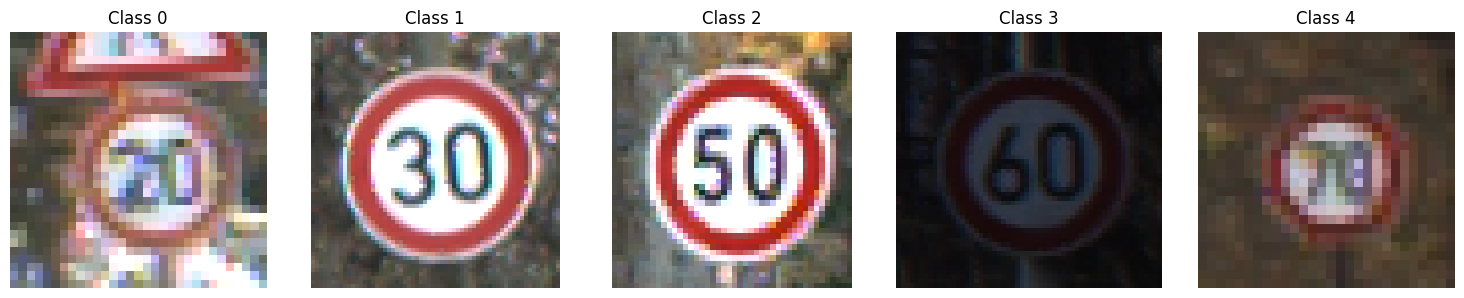

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import os

train_dir = 'gtsrb_data/Train'

classes = sorted(os.listdir(train_dir), key=lambda x: int(x))

# Виведемо по 1 зображенню з перших 5 класів
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, class_name in enumerate(classes[:5]):
    class_path = os.path.join(train_dir, class_name)
    img_files = [f for f in os.listdir(class_path) if f.endswith('.ppm') or f.endswith('.png') or f.endswith('.jpg')]
    img_path = os.path.join(class_path, img_files[0])

    image = Image.open(img_path)
    axs[i].imshow(image)
    axs[i].set_title(f"Class {class_name}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Трансформації: ресайз до 32x32, тензор, нормалізація
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Завантаження датасету
train_dataset = datasets.ImageFolder(root='gtsrb_data/Train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Перевіримо кількість класів
num_classes = len(train_dataset.classes)
print("Кількість класів:", num_classes)

Кількість класів: 43


##2. Тренування baseline моделі

Натренуємо класифікатор на ResNet18, а потім перевіримо, на скільки така модель буде вразливою до adversarial атак.

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

# Використання GPU, якщо доступний (має бути доступний, бо працюю у Google Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Завантаження ResNet18 без pretraining і адаптація під 43 класи
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
print("Модель готова. Працює на:", device)

Модель готова. Працює на: cuda


In [11]:
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Параметри
num_epochs = 10
patience = 3
best_acc = 0
epochs_no_improve = 0

# Розділення на train / val (70% / 30%)
val_ratio = 0.3
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

# Оптимізатор і функція втрат
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Трекинг метрик
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Функція валідації
def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    val_acc = 100. * correct / total
    val_loss = running_loss / len(val_loader)
    return val_acc, val_loss

# Навчання
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_postfix(loss=running_loss / (total / 64), acc=100. * correct / total)

    # Рахуємо метрики
    train_loss_avg = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    val_acc, val_loss = evaluate(model, val_loader)

    train_losses.append(train_loss_avg)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train acc = {train_acc:.2f}%, Val acc = {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("Найкраща модель збережена!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping — {patience} епох без покращення.")
            break

print(f"Навчання завершено. Найкраща валідаційна точність: {best_acc:.2f}%")

Epoch 1/10: 100%|██████████| 429/429 [00:23<00:00, 18.28it/s, acc=75.1, loss=0.833]


Epoch 1: Train acc = 75.08%, Val acc = 86.98%
Найкраща модель збережена!


Epoch 2/10: 100%|██████████| 429/429 [00:21<00:00, 20.13it/s, acc=93.8, loss=0.198]


Epoch 2: Train acc = 93.85%, Val acc = 95.09%
Найкраща модель збережена!


Epoch 3/10: 100%|██████████| 429/429 [00:21<00:00, 20.24it/s, acc=96, loss=0.128]


Epoch 3: Train acc = 95.96%, Val acc = 94.94%


Epoch 4/10: 100%|██████████| 429/429 [00:21<00:00, 20.18it/s, acc=97.5, loss=0.0824]


Epoch 4: Train acc = 97.51%, Val acc = 97.04%
Найкраща модель збережена!


Epoch 5/10: 100%|██████████| 429/429 [00:21<00:00, 19.98it/s, acc=97.5, loss=0.0799]


Epoch 5: Train acc = 97.53%, Val acc = 96.31%


Epoch 6/10: 100%|██████████| 429/429 [00:21<00:00, 20.22it/s, acc=98, loss=0.0643]


Epoch 6: Train acc = 97.99%, Val acc = 98.01%
Найкраща модель збережена!


Epoch 7/10: 100%|██████████| 429/429 [00:21<00:00, 20.18it/s, acc=98.4, loss=0.053]


Epoch 7: Train acc = 98.35%, Val acc = 97.90%


Epoch 8/10: 100%|██████████| 429/429 [00:21<00:00, 20.09it/s, acc=98.4, loss=0.0571]


Epoch 8: Train acc = 98.36%, Val acc = 97.73%


Epoch 9/10: 100%|██████████| 429/429 [00:21<00:00, 20.15it/s, acc=99, loss=0.0327]


Epoch 9: Train acc = 99.03%, Val acc = 98.15%
Найкраща модель збережена!


Epoch 10/10: 100%|██████████| 429/429 [00:21<00:00, 20.20it/s, acc=98.5, loss=0.0501]


Epoch 10: Train acc = 98.48%, Val acc = 96.96%
Навчання завершено. Найкраща валідаційна точність: 98.15%


In [12]:
# Оцінка найкращої моделі
model.load_state_dict(torch.load('best_model.pth'))
final_val_acc, _ = evaluate(model, val_loader)
print(f"Фінальна точність на validation: {final_val_acc:.2f}%")

Фінальна точність на validation: 98.15%


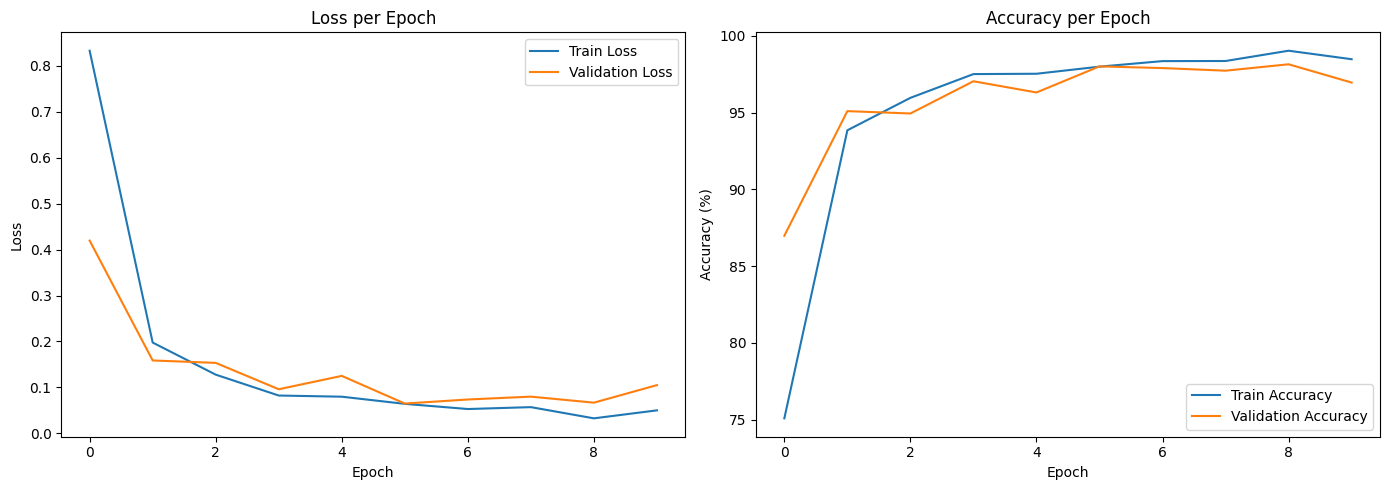

In [13]:
# Візуалізація графіків
plt.figure(figsize=(14, 5))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Early stopping не спрацювало, адже результат покращувався кожні 2 епохи, перенавчання немає. Можемо переходити до тестування атаки

##3. Adversarial Attack

In [14]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Для перевірки на вразливість моделі вибрано PGD атаку

In [16]:
import torchattacks

# Завантажуємо найкращу модель
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Створюємо атаку PGD
pgd_attack = torchattacks.PGD(model, eps=1/255, alpha=1/255/10, steps=10)

# Оцінка точності після атаки
def evaluate_under_attack(model, dataloader, attack):
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        adv_inputs = attack(inputs, labels)
        outputs = model(adv_inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100. * correct / total

# Запускаємо атаку
pgd_acc = evaluate_under_attack(model, val_loader, pgd_attack)
print(f"PGD Attack Accuracy: {pgd_acc:.2f}%")

PGD Attack Accuracy: 39.11%


In [17]:
print(f"Accuracy without attack: {final_val_acc:.2f}%")
print(f"Accuracy after PGD attack: {pgd_acc:.2f}%")
print(f"Accuracy drop due to attack: {final_val_acc - pgd_acc:.2f}%")

Accuracy without attack: 98.15%
Accuracy after PGD attack: 39.11%
Accuracy drop due to attack: 59.04%


Бачимо, що модель до атаки дуже вразлива (втрачає близько 60% точності). Нижче побачимо, як це візуально виглядає.

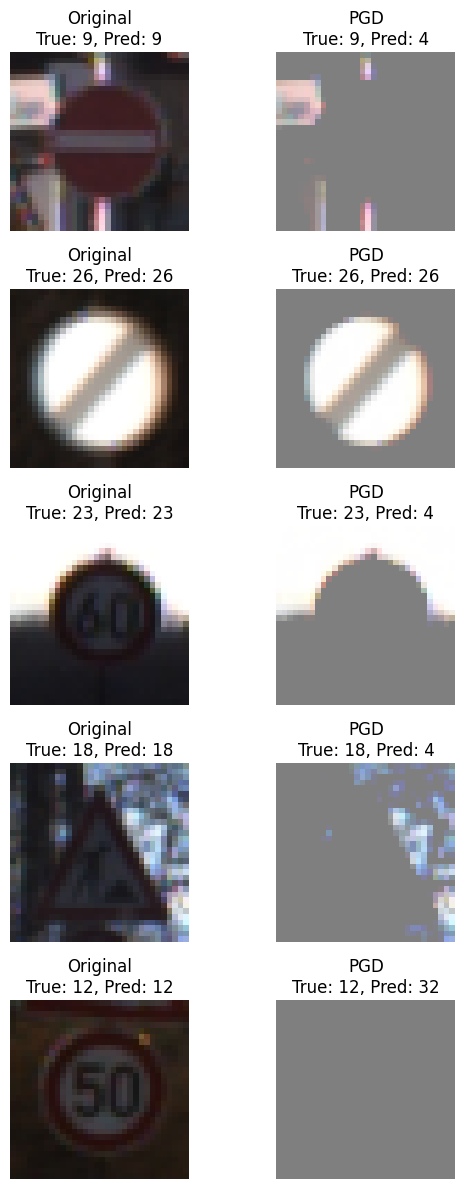

In [18]:
import matplotlib.pyplot as plt

# Функція для зворотної нормалізації (для Normalize((0.5,), (0.5,)))
def denormalize(tensor):
    return tensor * 0.5 + 0.5

# Модель у режимі eval
model.eval()
examples = []

# Отримуємо 5 прикладів з валідаційного loader
for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    adv_inputs = pgd_attack(inputs, labels)

    outputs_clean = model(inputs)
    outputs_adv = model(adv_inputs)

    _, pred_clean = outputs_clean.max(1)
    _, pred_adv = outputs_adv.max(1)

    for i in range(5):
        examples.append({
            "original": inputs[i].detach().cpu(),
            "adversarial": adv_inputs[i].detach().cpu(),
            "true_label": labels[i].item(),
            "pred_clean": pred_clean[i].item(),
            "pred_adv": pred_adv[i].item()
        })
    break  # беремо лише один батч

# Візуалізуємо
fig, axs = plt.subplots(5, 2, figsize=(6, 12))
for i, ex in enumerate(examples):
    # Original
    axs[i, 0].imshow(denormalize(ex["original"]).permute(1, 2, 0).clamp(0, 1).numpy())
    axs[i, 0].set_title(f"Original\nTrue: {ex['true_label']}, Pred: {ex['pred_clean']}")
    axs[i, 0].axis("off")

    # Adversarial
    axs[i, 1].imshow(denormalize(ex["adversarial"]).permute(1, 2, 0).clamp(0, 1).numpy())
    axs[i, 1].set_title(f"PGD\nTrue: {ex['true_label']}, Pred: {ex['pred_adv']}")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()

І останній графік для наочності:)

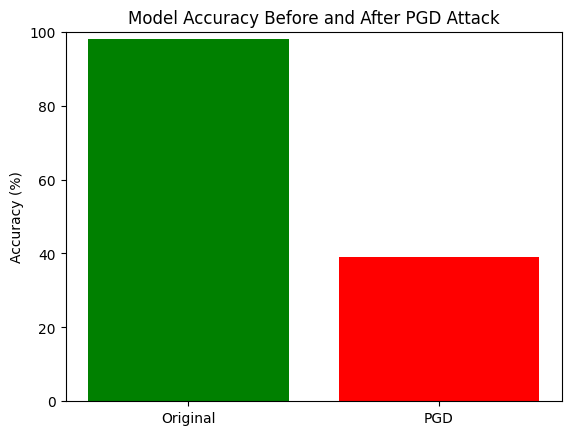

In [19]:
plt.bar(["Original", "PGD"], [final_val_acc, pgd_acc], color=["green", "red"])
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Before and After PGD Attack")
plt.ylim(0, 100)
plt.show()

**Можливі покращення (для покращення надійності моделі:**


1.   Порівняти ефективність PGD з іншими атаками, наприклад, FGSM, щоб наочно побачити різницю.
2.   Автоматизувати підбір параметрів атаки — наприклад, реалізувати grid search по eps та steps (основних параметрах, що контролюють, власне, атаку).
3. Аугментувати вхідні зображення при атаці (додавання шуму, обертання), щоб оцінити стійкість до комбінаційних впливів.
4. Провести adversarial training, щоб зробити модель стійкішою до атак (наприклад, навчати частково на PGD-прикладах).
5. Спробувати навчити іншу модель (наприклад, ResNet34 або EfficientNet) або ансамбль, щоб перевірити вплив архітектури на вразливість.
